In [1]:
import random

import numpy as np
from PIL import Image
import cv2

import torch
from torchvision.transforms import v2 as transforms

from keyrover import imshow, show_images
from keyrover.datasets import *
from keyrover.ml import get_device, BinarySegmentationModel
from keyrover.vision import *
from keyrover.math import quad_area

In [2]:
device = get_device()

In [3]:
image_paths = get_dataset_paths()
train_paths, test_paths, valid_paths = split_train_test_valid(image_paths, 0.8, 0.1)

SIZE = (480, 640)
test_dataset = BinaryKeyboardSegmentationDataset(test_paths, size=SIZE)

len(test_dataset)

  0%|          | 0/401 [00:00<?, ?it/s]

401

In [4]:
mean, std = get_dataset_norm_params(version=3)

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

test_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

In [5]:
ARCH = "unetplusplus"
BACKBONE = "resnet18"
name = "jumping-darkness-67"

LEARNING_RATE = None

model = BinarySegmentationModel(ARCH, BACKBONE, in_channels=3, out_classes=1, lr=None)
model.load_state_dict(torch.load(f"models/binary_segmentation/{name}-{ARCH}-{BACKBONE}-v3.pt", weights_only=True))
model.eval()
model.to(device)

BinarySegmentationModel(
  (model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.141747..2.9632897].


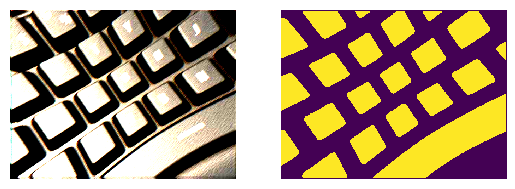

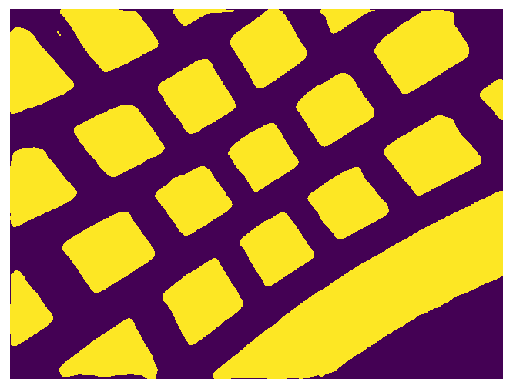

In [6]:
img, mask = test_dataset[random.randint(0, len(test_dataset) - 1)]
with torch.no_grad():
    pred = model(img.to(device).unsqueeze(0)).cpu().numpy()[0, 0]

imshow(img, mask)
imshow((pred > 1).astype("uint8"))

[[600 320]
 [639 320]
 [639 362]
 [600 362]]
[[527 352]
 [531 311]
 [585 316]
 [581 357]]
[[467 305]
 [512 305]
 [512 347]
 [467 347]]
[[393 331]
 [399 294]
 [447 301]
 [442 338]]
[[328 306]
 [330 288]
 [381 293]
 [379 311]]
[[103 297]
 [106 266]
 [309 280]
 [307 311]]
[[ 49 294]
 [ 54 258]
 [ 95 264]
 [ 89 300]]
[[518 297]
 [522 256]
 [643 270]
 [638 310]]
[[  2 286]
 [ 11 250]
 [ 45 258]
 [ 36 295]]
[[465 293]
 [467 253]
 [504 255]
 [502 295]]
[[412 287]
 [413 248]
 [448 249]
 [446 288]]
[[362 280]
 [365 244]
 [398 246]
 [395 283]]
[[316 275]
 [320 239]
 [351 242]
 [347 278]]
[[270 270]
 [275 234]
 [305 238]
 [301 274]]
[[223 266]
 [228 229]
 [260 234]
 [255 271]]
[[175 260]
 [183 221]
 [216 228]
 [207 268]]
[[128 257]
 [137 219]
 [169 226]
 [160 264]]
[[ 83 251]
 [ 94 213]
 [124 222]
 [113 259]]
[[ 42 247]
 [ 51 212]
 [ 78 219]
 [ 68 255]]
[[554 250]
 [557 209]
 [642 215]
 [638 256]]
[[ -2 242]
 [  0 209]
 [ 39 213]
 [ 36 246]]
[[495 244]
 [499 205]
 [537 208]
 [533 248]]
[[442 239]

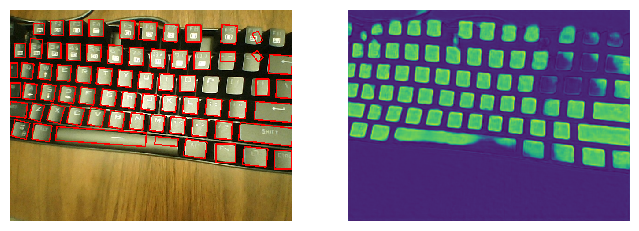

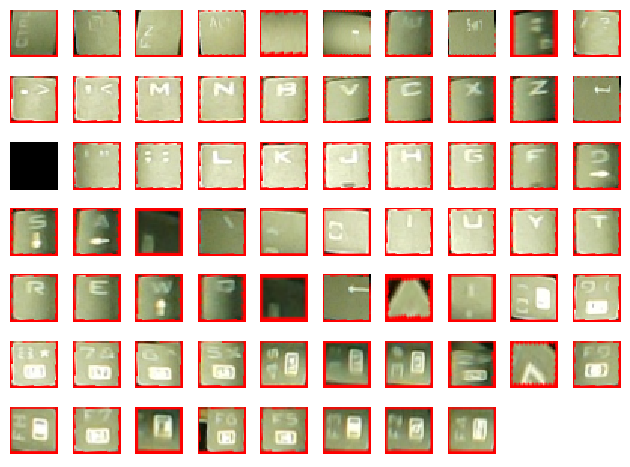

In [12]:
img = np.array(Image.open(f"datasets/test/1.jpg"))

with torch.no_grad():
    pred = model(transform(img).unsqueeze(0).to(device)).cpu().numpy()[0, 0]
mask = (pred > 0).astype("uint8")

keys = []
for rect in extract_rotated_rects(mask):
    if quad_area(*rect.flatten()) < 300:
        continue
    cv2.drawContours(img, [rect], -1, (255, 0, 0), 2)

    crop = crop_rect(img, rect)
    crop = cv2.resize(crop, (32, 32))
    keys.append(crop)

imshow(img, pred, figsize=(8, 8))
show_images(keys)